# Hate Speech Detector 2.0
---
**Statistical data analysis**
1. Yearly counts analysis (pie plot)
2. Monthly, weekdaily and hourly count analysis. (bar plot)
3. Timeline tweet counts analysis. (line plot)
4. Hate speech types analysis:
    1. Monthly, weekdaily and hourly count analysis of certain hate type analysis. (bar plot)
    2. Timeline tweet counts of certain hate type analysis. (line plot)
5. Tweets of certain hate type popularity - 8 histograms of following popularity measures (7 for each hate type and one for non-hate tweets)
    1. Like counts
    2. Retweet counts
    3. Reply counts

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from datetime import datetime

from src.dataframes.timeline import get_stats
from src.visualization.stats import (tweet_yearly_counts_pie, tweet_count_bars, tweets_timeline,
                                     popularity_hists)
from src.constants import (MONTH_NAMES, WEEKDAY_NAMES,
                           SPA_CHART_DIR)

In [2]:
pd.set_option('display.max_colwidth', 400)

In [3]:
plt.style.use('ggplot')

## Data loading
---

In [4]:
df_combined = pd.read_csv('data/tweets_sady/main/sady_combined.csv')
df_combined.head(2)

,id,date,time,user_id,username,name,tweet,emojis,emoticons,mentions,...,likes_count,wydźwięk,klucze,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
0,0,2014-06-06,21:41:42,2367137142,krzysztofcicho3,Krzysztof Cichosz,Dokładnie! Dlatego trzeba komuchów gonić przed sądy póki żyją. I mięć otwarte oczy na komuchów zakamuflowanych,NaN,NaN,['tomsokolewicz'],...,0,-1,komuchów; gonić komuchów,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2014-06-06,18:58:53,780543464,zalewski53,Roland Zalewski,Polska Polityka: Sądy bardziej bezkarne niż w PRL,NaN,NaN,[],...,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
dates = df_combined['date'].values
dates

array(['2014-06-06', '2014-06-06', '2014-06-06', ..., '2016-11-12',
       '2016-11-12', '2016-11-12'], dtype=object)

In [6]:
times = df_combined['time'].values
times

array(['21:41:42', '18:58:53', '18:52:58', ..., '15:43:14', '11:30:36',
       '08:59:37'], dtype=object)

In [7]:
years = np.array([int(d.split('-')[0]) for d in dates])
years

array([2014, 2014, 2014, ..., 2016, 2016, 2016])

In [8]:
months = np.array([int(d.split('-')[1]) for d in dates])
months

array([ 6,  6,  6, ..., 11, 11, 11])

In [9]:
weekdays = np.array([datetime.strptime(d, '%Y-%m-%d').weekday() for d in dates])
weekdays

array([4, 4, 4, ..., 5, 5, 5])

In [10]:
hours = np.array([int(t.split(':')[0]) for t in times])
hours

array([21, 18, 18, ..., 15, 11,  8])

In [11]:
df_yc, df_mc, df_wdc, df_hc, df_dc = get_stats(df_combined,
                                               month_names=MONTH_NAMES,
                                               weekday_names=WEEKDAY_NAMES)

## Yearly counts analysis
---

In [12]:
df_yc

,count
year,
2014,2286
2015,6676
2016,6240


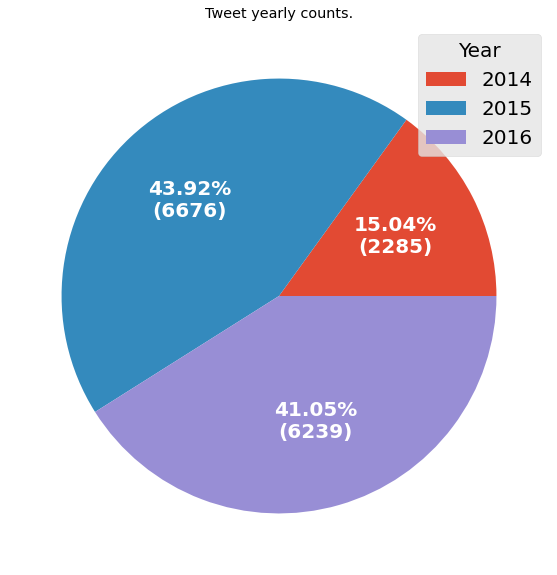

In [13]:
tweet_yearly_counts_pie(df_yc, save_file=SPA_CHART_DIR.replace('{}', 'tweet_yearly_counts_pie'))

## Monthly, weekdaily, hourly counts
---

In [14]:
df_mc

,count
month,
January,1073
February,988
March,631
April,333
May,103
June,826
July,1528
August,1709
September,2162


In [15]:
df_wdc

,count
weekday,
Monday,2323
Tuesday,2472
Wednesday,2664
Thursday,2396
Friday,2122
Saturday,1633
Sunday,1592


In [16]:
df_hc

,count
hour,
0,325
1,153
2,78
3,35
4,35
5,41
6,123
7,322
8,637


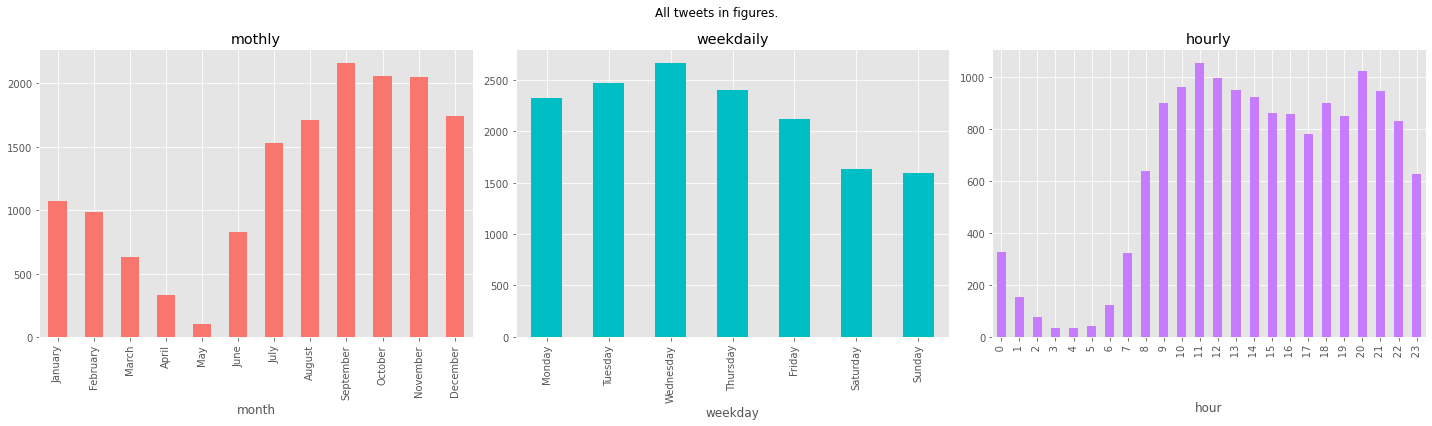

In [17]:
tweet_count_bars(df_mc, df_wdc, df_hc, save_file=SPA_CHART_DIR.replace('{}', 'tweet_count_bars'))

1. Most of tweets have come from months: september, october and november and the least from may.
2. Most of the tweets have been posted on Wednesday and the least on Saturday and Sunday.
3. Most of the tweets have been written around the midday (hours 10-13) and in the evening (hours 20, 21).

## Timeline amounts
---

In [18]:
df_dc

,count
date,
2014-06-06,8.0
2014-06-07,6.0
2014-06-08,5.0
2014-06-09,12.0
2014-06-10,15.0
...,...
2016-11-07,35.0
2016-11-08,26.0
2016-11-09,26.0


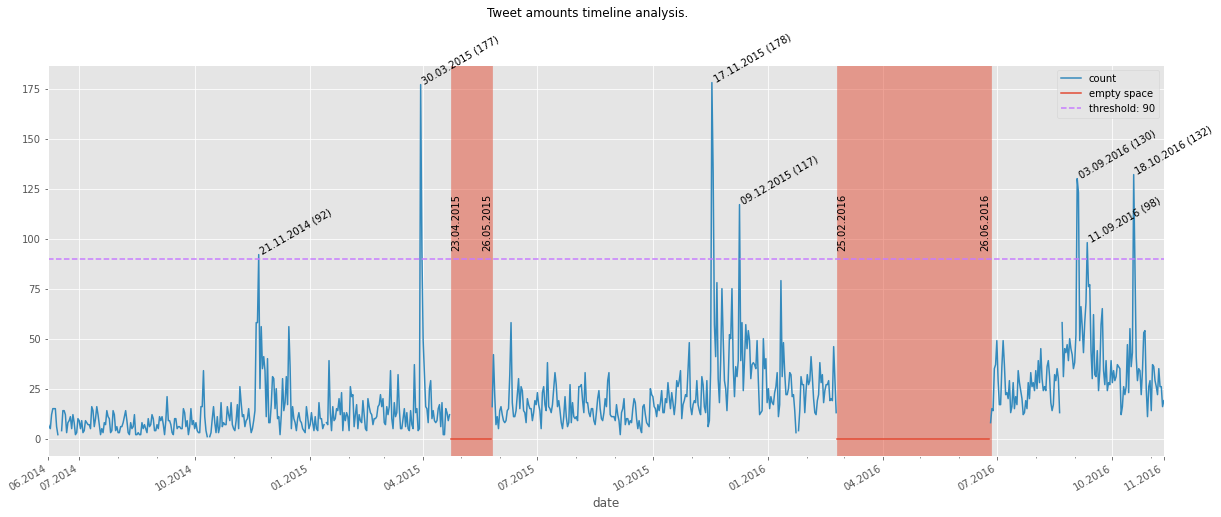

In [19]:
tweets_timeline(df_dc, empty_spaces=True, threshold=90,
                save_file=SPA_CHART_DIR.replace('{}', 'tweets_all_timeline'))

Some areas are empty due to the faulty mechanism of Twint scraper, i.e. faulty Internet connection. These will be filled after the best multi-label classification model will have been trained.

## Hate speech types analysis
---
* Monthly, weekdaily, hourly counts
* Timeline amounts (*have not been performed due to the lack of data*)

**Wyzywanie**

In [20]:
df_yc, df_mc, df_wdc, df_hc, df_dc = get_stats(df_combined, hate_type='wyzywanie',
                                               month_names=MONTH_NAMES,
                                               weekday_names=WEEKDAY_NAMES)

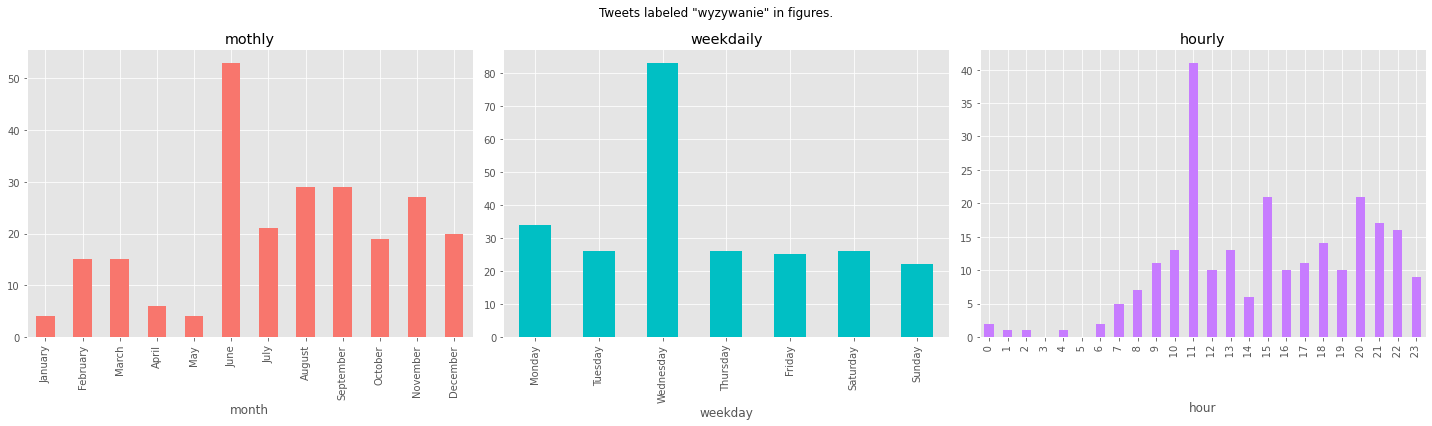

In [21]:
tweet_count_bars(df_mc, df_wdc, df_hc, title='Tweets labeled "wyzywanie" in figures.',
                 save_file=SPA_CHART_DIR.replace('{}', 'tweets_wyz_timeline'))

**Grożenie**

In [22]:
df_yc, df_mc, df_wdc, df_hc, df_dc = get_stats(df_combined, hate_type='grożenie',
                                               month_names=MONTH_NAMES,
                                               weekday_names=WEEKDAY_NAMES)

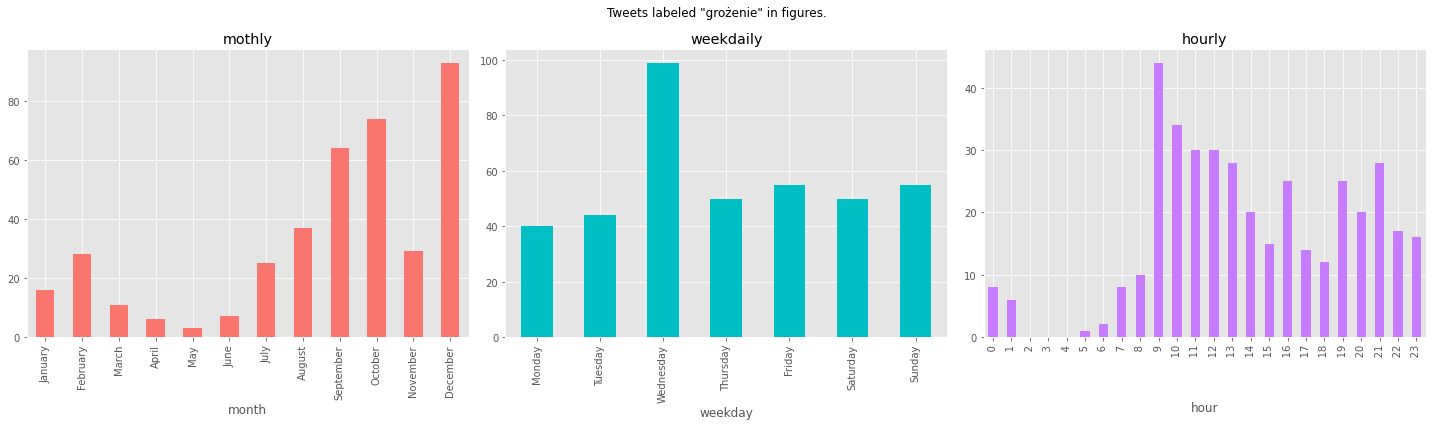

In [23]:
tweet_count_bars(df_mc, df_wdc, df_hc, title='Tweets labeled "grożenie" in figures.',
                 save_file=SPA_CHART_DIR.replace('{}', 'tweets_groz_timeline'))

**Wykluczanie**

In [24]:
df_yc, df_mc, df_wdc, df_hc, df_dc = get_stats(df_combined, hate_type='wykluczanie',
                                               month_names=MONTH_NAMES,
                                               weekday_names=WEEKDAY_NAMES)

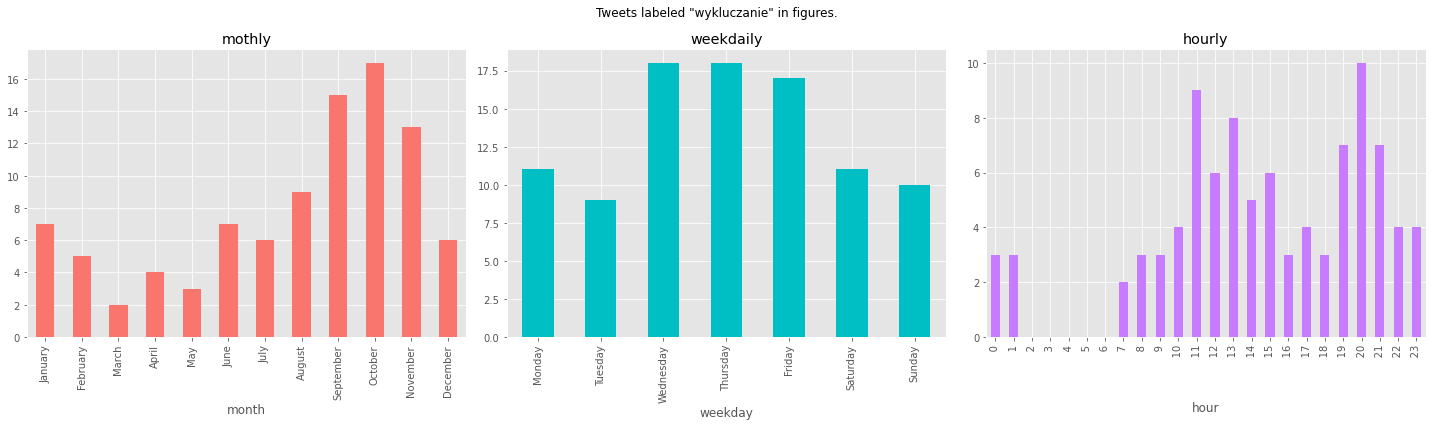

In [25]:
tweet_count_bars(df_mc, df_wdc, df_hc, title='Tweets labeled "wykluczanie" in figures.',
                 save_file=SPA_CHART_DIR.replace('{}', 'tweets_wyk_timeline'))

**Odczłowieczanie**

In [26]:
df_yc, df_mc, df_wdc, df_hc, df_dc = get_stats(df_combined, hate_type='odczłowieczanie',
                                               month_names=MONTH_NAMES,
                                               weekday_names=WEEKDAY_NAMES)

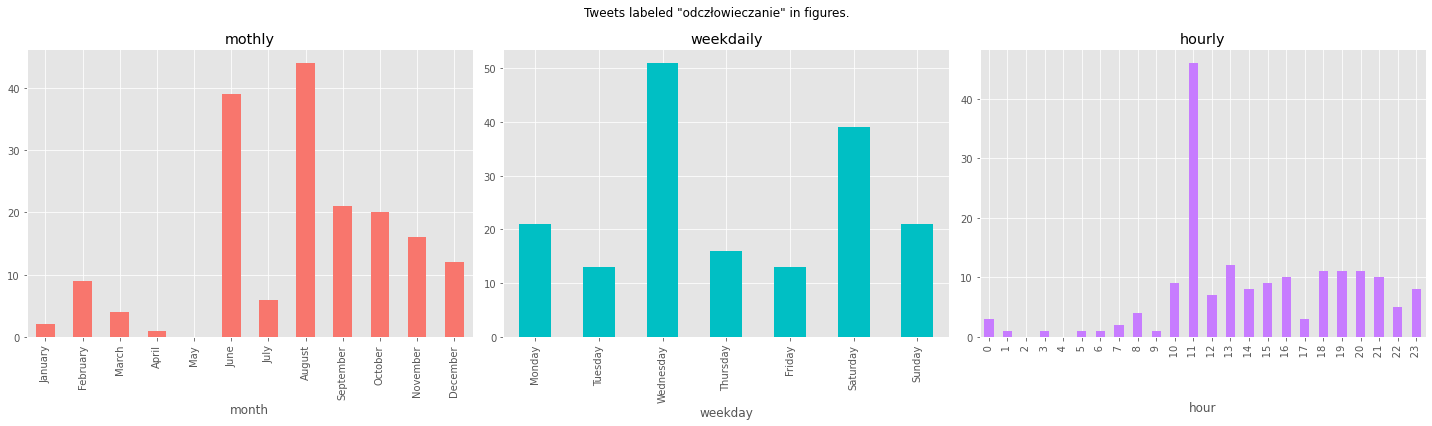

In [27]:
tweet_count_bars(df_mc, df_wdc, df_hc, title='Tweets labeled "odczłowieczanie" in figures.',
                 save_file=SPA_CHART_DIR.replace('{}', 'tweets_odcz_timeline'))

**Poniżanie**

In [28]:
df_yc, df_mc, df_wdc, df_hc, df_dc = get_stats(df_combined, hate_type='poniżanie',
                                               month_names=MONTH_NAMES,
                                               weekday_names=WEEKDAY_NAMES)

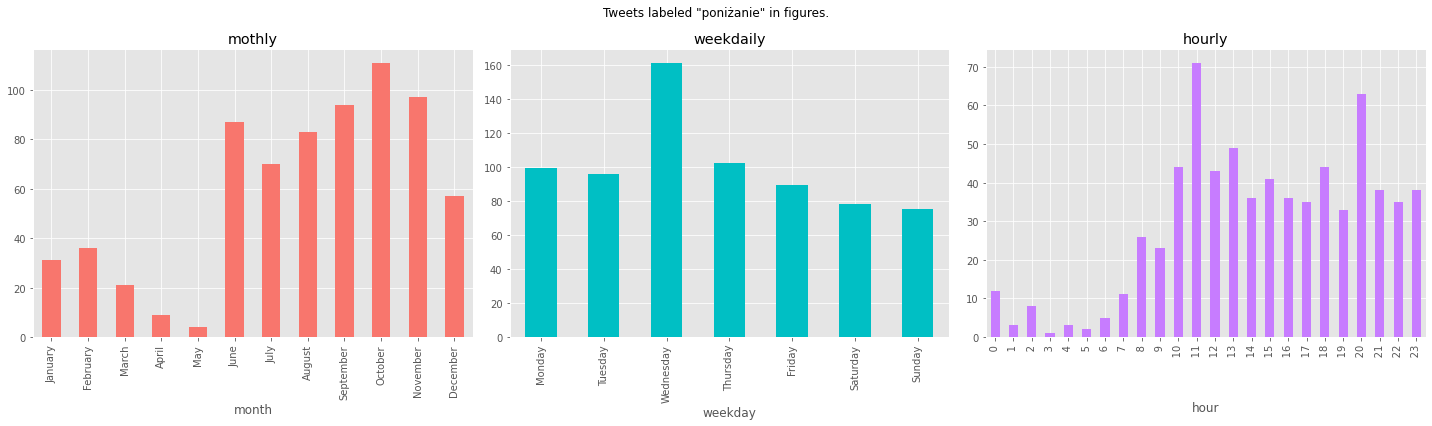

In [29]:
tweet_count_bars(df_mc, df_wdc, df_hc, title='Tweets labeled "poniżanie" in figures.',
                 save_file=SPA_CHART_DIR.replace('{}', 'tweets_pon_timeline'))

**Stygmatyzacja**

In [30]:
df_yc, df_mc, df_wdc, df_hc, df_dc = get_stats(df_combined, hate_type='stygmatyzacja',
                                               month_names=MONTH_NAMES,
                                               weekday_names=WEEKDAY_NAMES)

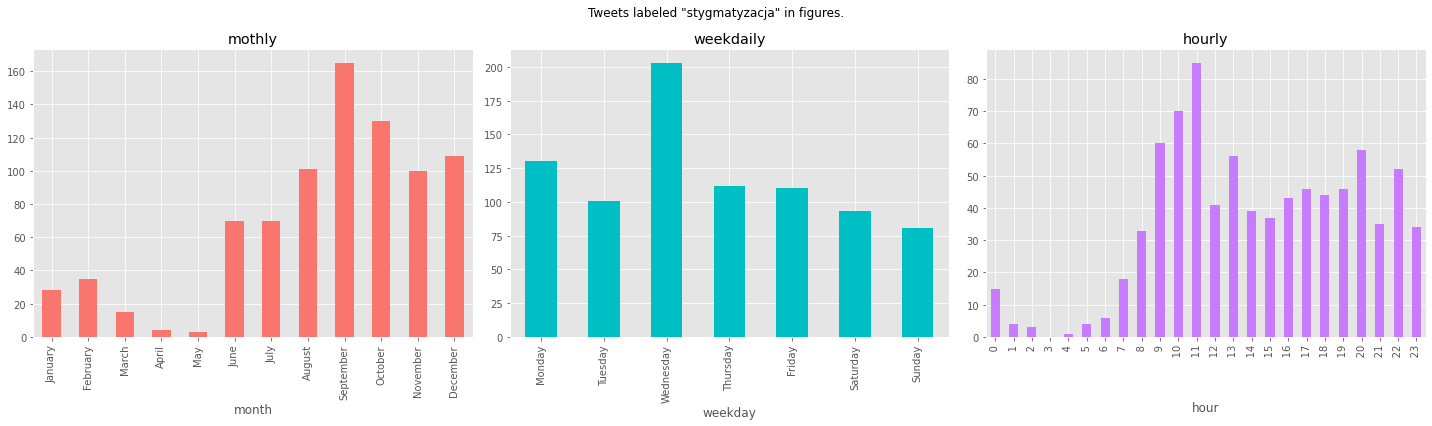

In [31]:
tweet_count_bars(df_mc, df_wdc, df_hc, title='Tweets labeled "stygmatyzacja" in figures.',
                 save_file=SPA_CHART_DIR.replace('{}', 'tweets_styg_timeline'))

**Szantaż**

In [32]:
df_yc, df_mc, df_wdc, df_hc, df_dc = get_stats(df_combined, hate_type='szantaż',
                                               month_names=MONTH_NAMES,
                                               weekday_names=WEEKDAY_NAMES)

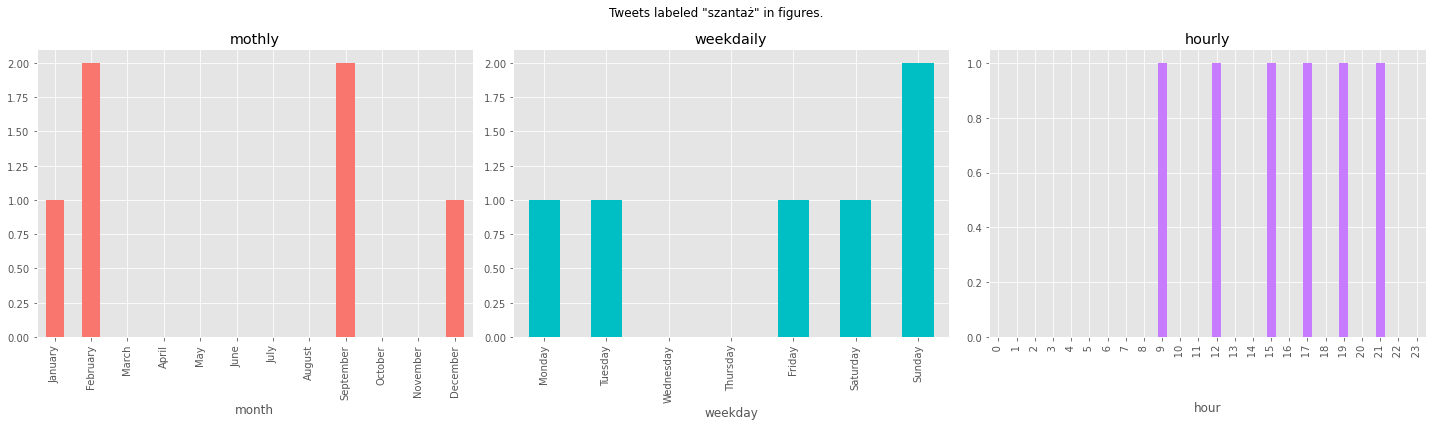

In [33]:
tweet_count_bars(df_mc, df_wdc, df_hc, title='Tweets labeled "szantaż" in figures.',
                 save_file=SPA_CHART_DIR.replace('{}', 'tweets_szan_timeline'))

## Tweets hate type popularity
---
* Likes
* Retweets
* Replies

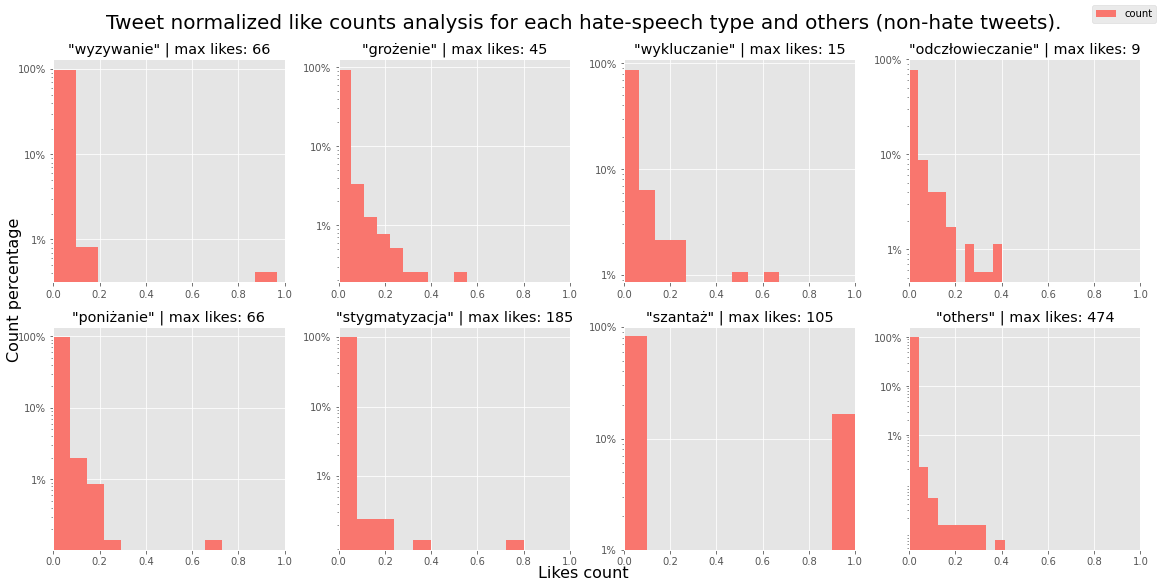

In [34]:
popularity_hists(df_combined, attribute='likes', color='#f9766e',
                 save_file=SPA_CHART_DIR.replace('{}', 'like_counts_hists'))

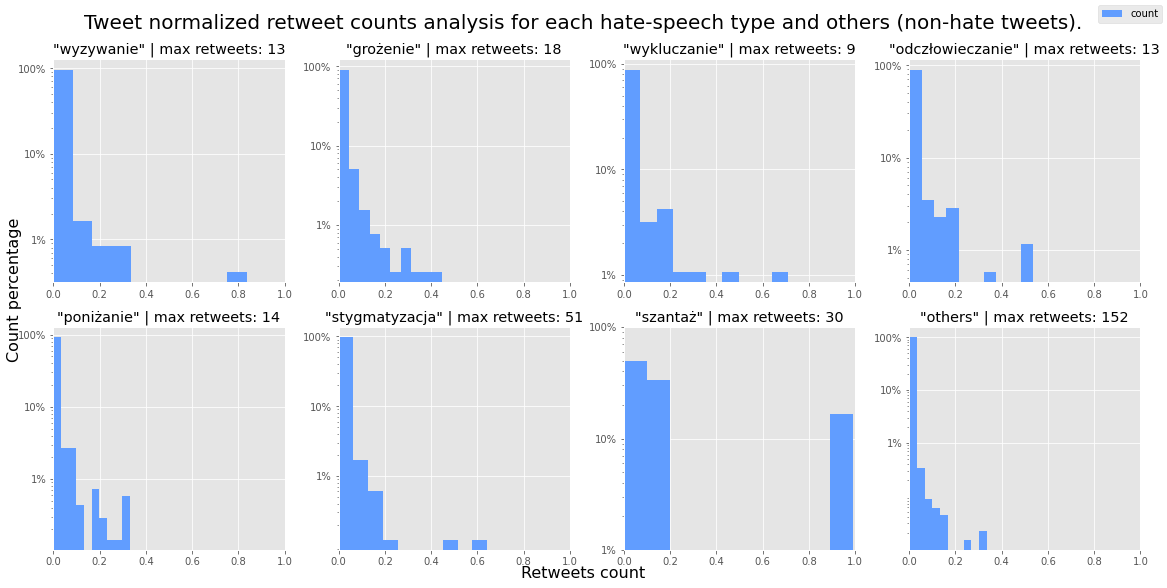

In [35]:
popularity_hists(df_combined, attribute='retweets', color='#619dff',
                 save_file=SPA_CHART_DIR.replace('{}', 'retweet_counts_hists'))

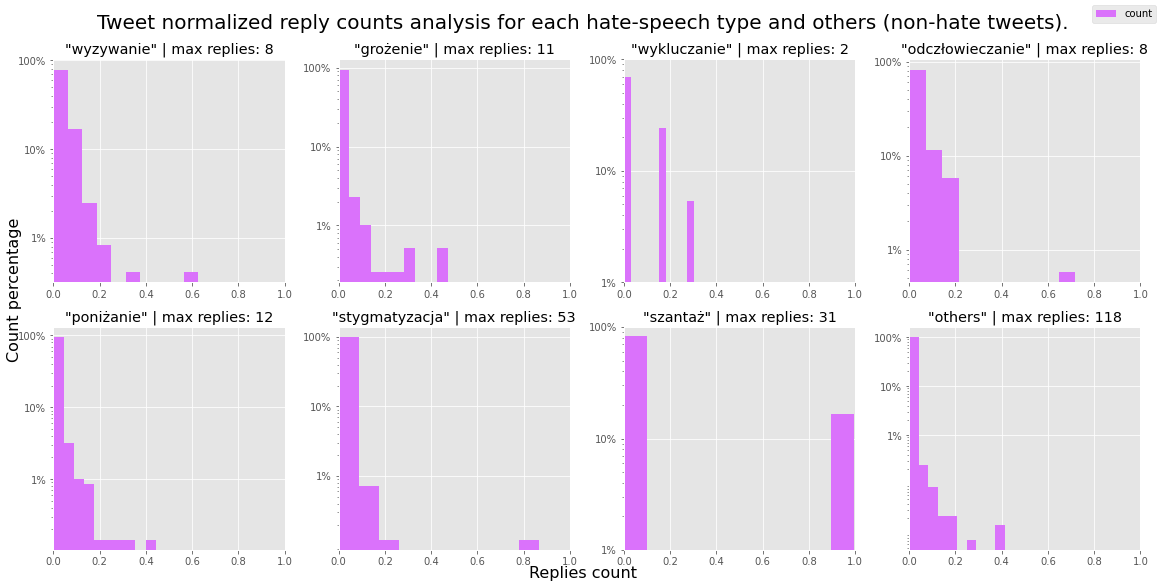

In [36]:
popularity_hists(df_combined, attribute='replies', color='#da72fb',
                 save_file=SPA_CHART_DIR.replace('{}', 'replies_counts_hists'))